In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import random
import os


averageAreaContour: 425.15
centerArray: [(27, 184), (193, 180), (254, 180), (87, 183), (46, 184), (65, 184), (234, 180), (213, 180), (224, 180), (27, 44), (92, 44), (252, 41), (84, 44), (191, 41), (42, 44), (67, 44), (53, 44), (232, 41), (211, 41), (221, 41)]


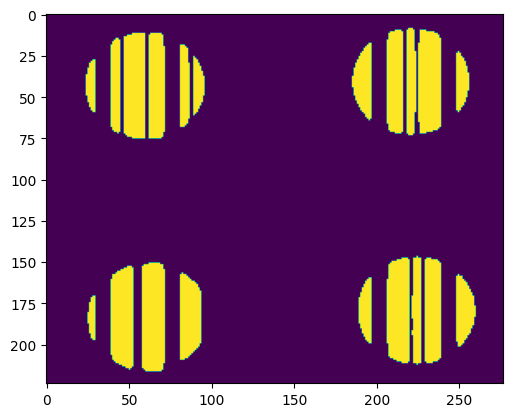

In [104]:
# img_path = "..\led_image\LEDID_4_RoI_adjusted.jpg"
img_path ="..\led_image\paper\paper_4_LED.png"
# img_path = "..\led_image\\2led.png"

img = cv2.imread(img_path)
height, width = img.shape[:2]
image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imageConvert = cv2.convertScaleAbs(image, alpha=255.0 / np.max(image))
_, threshold_imageConvert = cv2.threshold(
    imageConvert, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
contours, hierarchy = cv2.findContours(
    threshold_imageConvert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)


averageAreaContour = np.mean([cv2.contourArea(c) for c in contours])
print(f"averageAreaContour: {averageAreaContour}")
boundingBox = []

for contour in contours:
    area = cv2.contourArea(contour)
    if area > averageAreaContour / 10:
        x, y, w, h = cv2.boundingRect(contour)
        boundingBox.append((x, y, w, h))
        cv2.rectangle(imageConvert, (x, y), (x + w, y + h), (255, 255, 0), 2)

centerArray = []
center_with_box_data = []
for box in boundingBox:
    x, y, w, h = box
    center = (x + w // 2, y + h // 2)
    centerArray.append(center)
print(f"centerArray: {centerArray}")
# cv2.imshow('Image Window', threshold_imageConvert)
# cv2.waitKey(0)

# Close all OpenCV windows
# cv2.destroyAllWindows()
# print(f"centerArray: {centerArray}")
# plt.figure(figsize=(5, 5))  # Adjust figure size as needed
plt.imshow(threshold_imageConvert)
# plt.title("Image")
# plt.show()

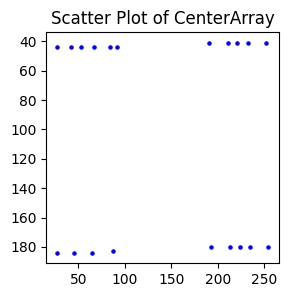

In [105]:
plt.figure(figsize=(3, 3))  # Adjust figure size as needed

# Create scatter plot
plt.scatter(*zip(*centerArray), marker="o", color="blue", s=5)

# Set title and axis labels
plt.title("Scatter Plot of CenterArray")
plt.xlabel("")
plt.ylabel("")
plt.gca().invert_yaxis()
plt.show()

In [106]:
def kmeans(data, k, max_iters):
    """Performs K-means clustering on data without using scikit-learn."""
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]  # Initial centroids

    for _ in range(max_iters):
        # Assign data points to closest centroid
        labels = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)

        # Update centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return labels

data = np.array(centerArray)
k = 4
max_iters = len(centerArray)

labels = kmeans(data, k, max_iters)
print(labels)

[3 2 2 3 3 3 2 2 2 1 1 0 1 0 1 1 1 0 0 0]


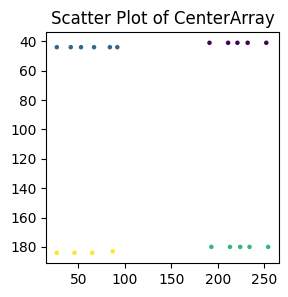

In [107]:
# kmeans = KMeans(n_clusters=4, random_state=0).fit_predict(centerArray)
# print(kmeans)
plt.figure(figsize=(3, 3))  # Adjust figure size as needed
plt.scatter(*zip(*centerArray),c = labels, marker="o", s=5)

# Set title and axis labels

plt.title("Scatter Plot of CenterArray")
plt.xlabel("")
plt.ylabel("")
plt.gca().invert_yaxis()
plt.show()

True

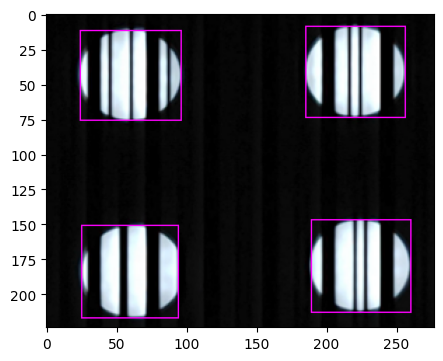

In [108]:
rois = []

for label in range(4):
        cluster_contours = [box for i, box in enumerate(boundingBox) if labels[i] == label]

        # Calculate ROI based on the contours in the cluster
        x_min = min(box[0] for box in cluster_contours)
        y_min = min(box[1] for box in cluster_contours)
        x_max = max(box[0] + box[2] for box in cluster_contours)
        y_max = max(box[1] + box[3] for box in cluster_contours)
        rois.append([x_min, y_min, x_max - x_min, y_max - y_min])
        
        # Draw rectangle around the LED
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 255), 1)

plt.figure(figsize=(5, 5))  # Adjust figure size as needed
plt.imshow(img)
# plt.title("Image")
# plt.show()
cv2.imwrite("input_paper2.png", img)